In [25]:
#Stock Portfolio Value Simulation Model (Correlated GBM)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import datetime
from scipy.stats import norm

In [26]:
#Portfolio Data Import + Input
tickers = 'AAPL', 'MSFT', 'NVDA', 'XOM', 'F', 'SPCE', 'KO'
startDate = '2024-06-01'
endDate = datetime.datetime.now()
closepricedata = yf.download(tickers, startDate,endDate) ['Close']
closeprices = np.array(closepricedata.tail(1))
n_of_stocks = np.array([20,15,18,12,5,100,14])
portfolio_value_today = np.sum(closeprices @ n_of_stocks)

[*********************100%***********************]  7 of 7 completed


In [27]:
#Portfolio Mean Daily Return and Std Calc
daily_ln_return = np.log(closepricedata/closepricedata.shift(1)).dropna()
daily_mean_ln_return = np.mean(daily_ln_return, axis=0).to_numpy()
daily_std_ln_return = np.std(daily_ln_return, axis=0).to_numpy()
cov_matrix = daily_ln_return.cov().to_numpy()
corr_matrix = daily_ln_return.corr().to_numpy()

In [28]:
#Stock Price Simulation
n_of_simulations = 100000
n_of_days = 252
dt = 1
# Cholesky Decomposition for Correlated Random Variables
L = np.linalg.cholesky(cov_matrix)

# Correlated GBM Simulation
def simulate_portfolio():
    # Generate correlated random shocks
    uncorrelated_shocks = norm.ppf(np.random.rand(n_of_days, len(tickers)))
    correlated_shocks = uncorrelated_shocks @ L.T
    
    # Calculate daily returns for each asset
    drift = (daily_mean_ln_return - 0.5 * daily_std_ln_return**2) * dt
    diffusion = correlated_shocks * daily_std_ln_return * np.sqrt(dt)
    daily_returns = np.exp(drift + diffusion)
    
    # Calculate price paths
    price_paths = np.zeros((n_of_days+1, len(tickers)))
    price_paths[0] = closeprices
    for t in range(1, n_of_days+1):
        price_paths[t] = price_paths[t-1] * daily_returns[t-1]
    
    # Calculate portfolio values
    portfolio_values = price_paths @ n_of_stocks
    return portfolio_values[-1]  # Return final portfolio value

# Run simulations (vectorized for better performance)
final_values = np.array([simulate_portfolio() for _ in tqdm.tqdm(range(n_of_simulations), 
                                                         desc="Running simulations", 
                                                         unit="sim")])

Running simulations: 100%|██████████| 100000/100000 [00:26<00:00, 3776.57sim/s]


In [29]:
# Calculate statistics
mean_final = np.mean(final_values)
median_final = np.median(final_values)
std_final = np.std(final_values)
percentile_5 = np.percentile(final_values, 5)
percentile_95 = np.percentile(final_values, 95)
prob_loss = np.sum(final_values < portfolio_value_today)/n_of_simulations

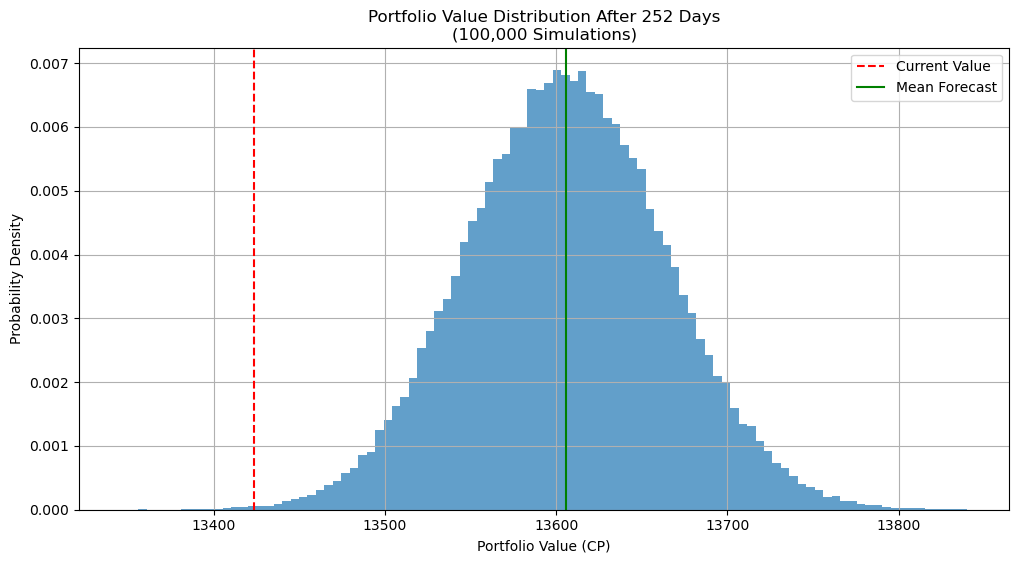


Portfolio Simulation Results (252 Days Ahead)
Current Value: $13,423.67
Mean Forecast: $13,605.96 (+1.36%)
Median Forecast: $13,605.71
Standard Deviation: $58.37
5th Percentile: $13,510.55
95th Percentile: $13,702.24
Probability of Loss: 0.10%


In [30]:
# Visualization
plt.figure(figsize=(12, 6))
plt.hist(final_values, bins=100, density=True, alpha=0.7)
plt.axvline(portfolio_value_today, color='r', linestyle='--', label='Current Value')
plt.axvline(mean_final, color='g', linestyle='-', label='Mean Forecast')
plt.title(f'Portfolio Value Distribution After {n_of_days} Days\n({n_of_simulations:,} Simulations)')
plt.xlabel('Portfolio Value (CP)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"\nPortfolio Simulation Results ({n_of_days} Days Ahead)")
print(f"Current Value: ${portfolio_value_today:,.2f}")
print(f"Mean Forecast: ${mean_final:,.2f} ({mean_final/portfolio_value_today-1:+.2%})")
print(f"Median Forecast: ${median_final:,.2f}")
print(f"Standard Deviation: ${std_final:,.2f}")
print(f"5th Percentile: ${percentile_5:,.2f}")
print(f"95th Percentile: ${percentile_95:,.2f}")
print(f"Probability of Loss: {prob_loss:.2%}")